# Clustering Customers with RFM Method

In this assignment, we're going to cluster customers based on their behaviours in terms of **R**ecency, **F**requency, and **M**onetary. K-Means will be used for clustering.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly as py
import plotly.graph_objs as go
import plotly.express as px

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs

from scipy.cluster.hierarchy import dendrogram, linkage


import warnings
import os
warnings.filterwarnings("ignore")


## Exploration and Replacing Error Values

In [2]:
df = pd.read_csv("../input/clustering/transactions.csv")
df.head()

,customer_id,trans_date,trans_amount
0,CS5295,11-Feb-18,35
1,CS4768,15-Mar-20,39
2,CS2122,26-Feb-18,52
3,CS1217,16-Nov-16,99
4,CS1850,20-Nov-18,78


In [3]:
df.shape

(125000, 3)

In [4]:
df['customer_id'].nunique()

6889

According to brief exploration, we know that the dataset contains of 125000 rows and only 3 columns. Columns are customer id, transaction date, and amount. Among the 125000 rows, there are only 6889 unique customers.

In [5]:
df.describe()

,trans_amount
count,125000.000000
mean,64.991912
std,22.860006
min,10.000000
25%,47.000000
50%,65.000000
75%,83.000000
max,105.000000


In [6]:
df['trans_amount'].isnull().sum()

0

In transaction amount, there is no null value, and none of them are 0 or negative. But let's see about date. Will there be any incorrect dates in the transaction dates?

In [7]:
df['trans_date'].isnull().sum()

0

In [8]:
# Transaction date is still in string.
# For further processing, convert it to Pandas Datetime
# Find incorrect date by coercing the errors into NaT
df['trans_date_correct'] = pd.to_datetime(df['trans_date'],errors='coerce')
# Print unique incorrect date that has been found
df[df['trans_date_correct'].isnull()]['trans_date'].unique()

array(['29-Feb-17'], dtype=object)

There is an incorrect date, 29 Feb 2017, and we should replace this to 1 March 2017

In [9]:
df['trans_date'] = pd.to_datetime(df['trans_date'],errors='coerce').fillna(pd.to_datetime('01-Mar-17'))
df['trans_date'].isnull().sum()

0

In [10]:
print(df['trans_date'].min())
print(df['trans_date'].max())

2016-05-16 00:00:00
2020-03-16 00:00:00


After replacing error date, there are no null/incorrect dates anymore. Transactions in this dataset are between 16 May 2016 and 16 March 2020.

## Pre-Processing

For clustering, we use this principal to create features:

- Recency (how recent was the customer's last purchase), 
- Frequency (how often did the customer make a purchase in a given period) and
- Monetary (how much money did the customer spend in a given period)

First, let's create time difference in terms of days between transaction dates and today's date.

In [11]:
# Creating day difference
df['days_diff'] = (pd.Timestamp.today() - df['trans_date']).dt.days

To create features per customer, groupby and agg methods are used. <br>
For recency, use the lowest value of days_diff. <br>
For total money spent (monetary), use sum for trans_amount. <br>
For frequency, use count for customer_id. <br>

In [12]:
# Group the dataset to create features
df_rfm = df.groupby(['customer_id']).agg({
    'days_diff' : min, # last transaction, shows recency
    'trans_amount' : sum, # total money spent per customer, shows monetary
    'customer_id' :"count" # frequency of customer
})

df_rfm.head()

,days_diff,trans_amount,customer_id
customer_id,,,
CS1112,573,1012,15
CS1113,547,1490,20
CS1114,544,1432,19
CS1115,522,1659,22
CS1116,715,857,13


In [13]:
# Scale Features for easing clustering
sc = StandardScaler()
df_std = pd.DataFrame(sc.fit_transform(df_rfm))
df_std.columns = df_rfm.columns
df_std.head()

,days_diff,trans_amount,customer_id
0,-0.226203,-0.359103,-0.605640
1,-0.530157,0.667091,0.357262
2,-0.565229,0.542574,0.164682
3,-0.822421,1.029909,0.742423
4,1.433854,-0.691865,-0.990801


For viewing the distribution and trends between features, let's do pair plot.

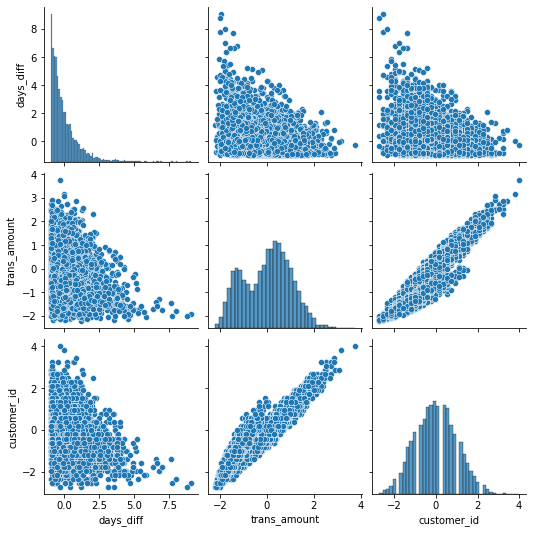

In [14]:
# Rename columns
sns.pairplot(df_std, diag_kind="hist")

For notes:
- customer_id represents frequency
- trans_amount means monetary
- days_diff means recency <br>

Based on the plots above, there seems a linear relationship between frequency and monetary. With respect to recency, there are no obvious relationship between this feature and frequency & monetary.

## K-Means

In [15]:
# rename columns
df_std.columns = [['recency', 'monetary', 'frequency']]

In [16]:
# Plotting Inertia & Silhouette for Determining K
def k_means_inertia_silhouette(X, k_max = 10, init = 'k-means++'):
    inertia = []
    silhouette = []
    for k in range(2, k_max):
        km =  KMeans(init = init, n_clusters = k, random_state= 123)
        km.fit(X)
        inertia.append(km.inertia_)
        silhouette.append(silhouette_score(X, km.labels_))
    
    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , inertia , 'o')
    plt.plot(np.arange(2 , k_max) , inertia , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
    plt.title('The Elbow method using Inertia for each number of cluster')
    plt.show()

    plt.figure(1 , figsize = (15 ,6))
    plt.plot(np.arange(2 , k_max) , silhouette , 'o')
    plt.plot(np.arange(2 , k_max) , silhouette , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters') , plt.ylabel('Silhouette')
    plt.title('Silhouette score for each number of cluster')
    plt.show()
    
    return inertia, silhouette

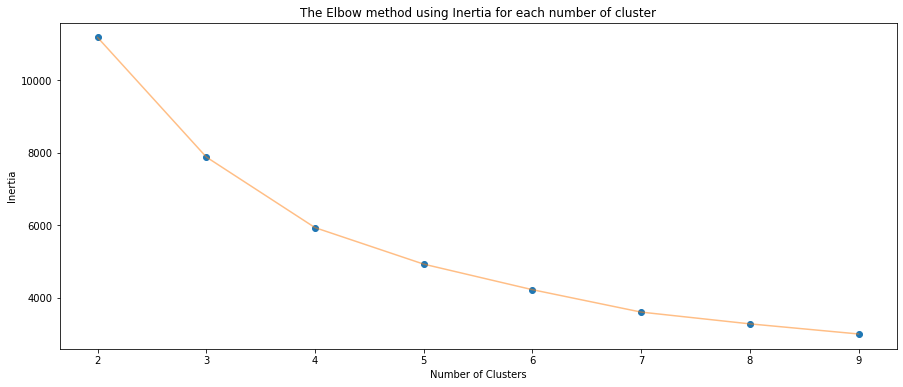

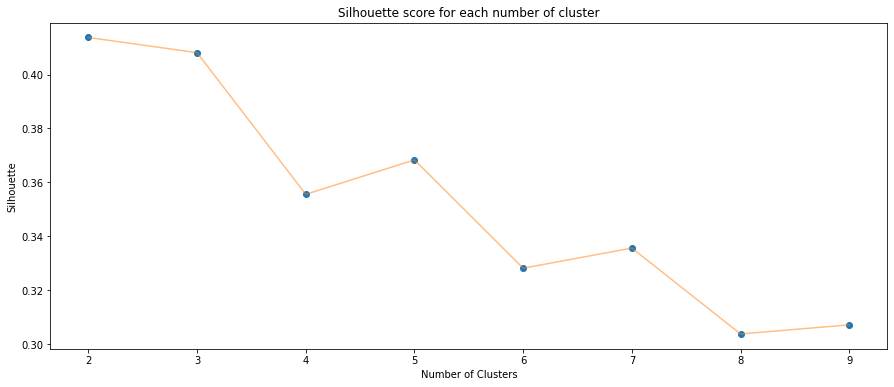

In [17]:
inertia, silhouette = k_means_inertia_silhouette(X = df_std)

Based on the inertia plot, it seems that from k = 5, the graphs seems starting to flatten. Let's use k = 5 for clustering with K-Means.

In [18]:
k = 5
k_means = KMeans(init = "k-means++", n_clusters = k, random_state= 123)
k_means.fit(df_std)

KMeans(n_clusters=5, random_state=123)

In [19]:
df_rfm.columns =  [['recency', 'monetary', 'frequency']]

# Append Labels to df_rfm, so that characteristic for 
# each clusters are easier to understand 
df_rfm['Segment'] = list(map(str, k_means.labels_))
fig = px.scatter_3d(x=df_rfm['recency'].values.ravel(), 
                    y=df_rfm['frequency'].values.ravel(), 
                    z=df_rfm['monetary'].values.ravel(),
                    color = df_rfm['Segment'].values.ravel(),
                   labels={
                             "x": "Recency",
                             "y": "Frequency",
                             "z": "Monetary"
                         },
                title="Clustering via K-Means++")
fig.show()

Based on the plot above, we can infer that:

Cluster Red:
1. Last transactions are quite recent
2. Total spent and frequency is medium-high
3. We can call: "Soulmate", since their characteristics are most likely company's favorites

Cluster Blue:
1. Last transactions are quite recent
2. Total spent and frequency is medium
3. We can call: "BFF", since transactions are quite recent and total spent and frequency are favourable/medium

Cluster Purple:
1. Last transactions are not as recent as Cluster Blue, 
2. Transactions are more frequent and Total spent is higher than Cluster Blue
3. We can call: "Old-time Pal", since we haven't seen them for a while yet in terms of total transactions & frequency, the numbers are favourable enough (medium)

Cluster Orange:
1. Last transactions are quite recent 
2. Total spent and frequency are medium to low
3. We can call: "New Crush", since these customers had transaction quite recently (checking "us" out), and it seems there are some potentials to make them our close/top customers.

Cluster Green:
1. Last transactions are long ago, older than the other clusters 
2. Total spent and frequency are medium to low
3. We can call: "Stranger", since they haven't had transactions for a long time

Based on the plot above, the clusters are quite similar to the K-Means we used before, but the difference is that there are some noises/outliers that are colored turquoise.

## Conclusion

From the clustering process above, we define 5 clusters with each characteristics based on K-Means with k = 5:
1. **Soulmate** : Customers who quite recently had transactions and are frequently shopping with high total amount of transaction.
2. **BFF** : Customers whose transactions are quite recent, but frequency and total amount are favourable/medium
3. **Old-time Pal** : Customers that we haven't seen for some time, but total transactions & frequency are favourable/medium
4. **New Crush** : Customers who recently enough had transaction, but total transactions & frequency are quite small/low
5. **Stranger** : Customers who doesn't have transaction for a long time, total transactions & frequency are quite small/low <br>

Here are some general quantitative charateristics for each clusters.


| Cluster Name     | Recency | Frequency | Monetary |
|------------------|---------|-----------|----------|
| **Soulmate**     | < 780   | > 20      | > 1650   |
| **BFF**          | < 600   | 15-20     | 800-1500 |
| **Old-time Pal** | 600-900 | 15-26     | 900-2000 |
| **New Crush**    | < 700   | < 15      | < 800    |
| **Stranger**     | > 680   | < 15      | < 1500   |

